In [ ]:
# -
# Script to generate jets images from JETCLASS: A Large Dataset for DeepLearning in Jet Physics.
# link: https://zenodo.org/records/6619768
#
# The following example concerns the creation of images from Higgs decay in b-channel
#
#import sys
#sys.path.append('/eos/user/f/fcampono/.local/lib/python3.11/site-packages') 

import cv2
import time
import os
import pandas as pd
import numpy as np
import awkward as ak
import uproot
import vector
import fastjet
import logging
from matplotlib import pyplot as plt
from energyflow.utils import (center_ptyphims, reflect_ptyphims, rotate_ptyphims, pixelate)
import json

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

# Registrazione dei vettori
vector.register_awkward()

In [ ]:
# -
# Read the .root file 
def read_file(
        filepath,
        max_num_particles=200,
        particle_features=['part_pt', 'part_eta', 'part_phi', 'part_energy'],
        jet_features=['jet_pt', 'jet_eta', 'jet_phi', 'jet_energy'],
        labels=['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q',
                'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']):

    def _pad(a, maxlen, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    table = uproot.open(filepath)['tree'].arrays()

    p4 = vector.zip({'px': table['part_px'],
                     'py': table['part_py'],
                     'pz': table['part_pz'],
                     'energy': table['part_energy']})
    table['part_pt'] = p4.pt
    table['part_eta'] = p4.eta
    table['part_phi'] = p4.phi

    x_particles = np.stack([ak.to_numpy(_pad(table[n], maxlen=max_num_particles)) for n in particle_features], axis=1)
    x_jets = np.stack([ak.to_numpy(table[n]).astype('float32') for n in jet_features], axis=1)
    y = np.stack([ak.to_numpy(table[n]).astype('int') for n in labels], axis=1)

    return x_particles, x_jets, y

# -
# Coord. change
def changeVector(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    e = np.sqrt(pt**2 + pz**2)
    return e, px, py, pz

# -
# Change period 
def wrap_phi(phi):
    return (phi + np.pi) % (2 * np.pi) - np.pi

# -
# Read file path
def get_filepaths(base_dir, num_parts=10, num_files_per_part=10, exclude_files=None):
    if exclude_files is None:
        exclude_files = []  
    
    filepaths_list = []
    for i in range(num_parts):  # 0 to 9
        part_dir = os.path.join(base_dir, f"JetClass_Pythia_train_100M_part{i}")
        for j in range(num_files_per_part):  # 000 to 009, 010 to 019, etc.
            filename = f"HToBB_{i*10 + j:03d}.root"  # Filename of the root file
            
            
            if f"{i*10 + j:03d}" not in exclude_files:
                filepath = os.path.join(part_dir, filename)
                filepaths_list.append(filepath)
    
    return filepaths_list

In [ ]:
# -
# PARAMETERS
N_JETS = 100000

MAX_IMAGES = 500
NUM_BLOBS = 1000
NUM_BLOBS_SUB = 10

NUM_PIXEL = 100
NUM_ZOOM  = 1.6

image_count = 0
images_id = 0

In [ ]:
# -
# Directory root file
base_dir = "/eos/user/f/fcampono/PRIN_JetImgs/Dataset/Dataset_root/"
#
exclude_files = []
list_dir = get_filepaths(base_dir, exclude_files=exclude_files)

In [ ]:
# - 
# Iteration over the root file
for index_root in range(len(list_dir)):
    if image_count == MAX_IMAGES:
        print("Maximum number of images generated. Process stopped.")
        break

    filepath = list_dir[index_root]
    print(f"Starting processing of file {index_root + 1}/{len(list_dir)}: {filepath}")

    try:
        x_particles, x_jet, y = read_file(filepath)
        jetdef1 = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.5) # cluster with R= 1.5
        rows = []

        for count, (particles, jet) in enumerate(zip(x_particles[:N_JETS], x_jet[:N_JETS])):
            partons = []
            for i in range(particles.shape[1]):
                pt, eta, phi, en = particles[0][i], particles[1][i], particles[2][i], particles[3][i]
                if pt > 0:
                    e, px, py, pz = changeVector(pt, eta, phi)
                    partons.append(fastjet.PseudoJet(float(e), float(px), float(py), float(pz)))

            cs1 = fastjet.ClusterSequence(partons, jetdef1)
            jets = sorted(cs1.inclusive_jets(), key=lambda j: j.pt(), reverse=True)
            
            # -
            # Dataframe generation
            for idx, subjet in enumerate(jets):
                row = {
                    'jet': count + 1,
                    'subjet_index': idx + 1,
                    'pt_subjet': subjet.pt(),
                    'eta_subjet': subjet.eta(),
                    'phi_subjet': subjet.phi(),
                }

                for k, c in enumerate(subjet.constituents()):
                    row[f'pt_cost_{k}'] = c.pt()
                    row[f'eta_cost_{k}'] = c.eta()
                    row[f'phi_cost_{k}'] = c.phi()

                rows.append(row)

        df = pd.DataFrame(rows)
        df_filtrato = df.fillna(0.0)

        #-
        # phi-wrap...in accordance with Energyflow conventions.
        phi_cols = [col for col in df_filtrato.columns if col.startswith('phi_cost_')]
        df_filtrato[phi_cols] = df_filtrato[phi_cols].apply(wrap_phi)

        image_sum = np.zeros((NUM_PIXEL, NUM_PIXEL))
        blob_number = 0

        n_jet_total = int(df_filtrato['jet'].max())
        n_valid_jet = (n_jet_total // NUM_BLOBS) * NUM_BLOBS

        for i in range(1, n_valid_jet + 1):
            df_new = df_filtrato[df_filtrato['jet'] == i].iloc[:, 5:]
            columns = df_new.shape[1]
            columns_res = int(columns / 3)

            events_array = df_new.values.reshape(-1, columns_res, 3)
            events_centered = [center_ptyphims(event, center='ptscheme') for event in events_array]
            events_reflected_and_rotated = [reflect_ptyphims(rotate_ptyphims(event, center='ptscheme')) for event in events_centered]

            images = [pixelate(event,
                               npix=NUM_PIXEL,
                               img_width=NUM_ZOOM,
                               nb_chan=1,
                               norm=False,
                               charged_counts_only=False) for event in events_reflected_and_rotated]

            images = np.array(images).reshape(len(images), NUM_PIXEL, NUM_PIXEL)
            image_sum += np.sum(images, axis=0)

            blob_number += 1
        
            # === Reached 1000 jets for a single image ===
            if blob_number == NUM_BLOBS:
                image_log_1000 = np.log1p(image_sum)
                out_path_1000 = f"/eos/user/f/fcampono/Jets_images/imgs/npy_HToBB/npy_HToBB_1000/HToBB_1000_fileroot_{index_root:03d}_id_{images_id:03d}.npy"
                np.save(out_path_1000, image_log_1000)
        
                # Reset for the next group
                image_count += 1
                images_id += 1
                image_sum = np.zeros((NUM_PIXEL, NUM_PIXEL))
                blob_number = 0
        
                if image_count == MAX_IMAGES:
                    break

    except Exception as e:
        print(f"Error while processing file {filepath}: {e}")
        continue

In [ ]:
# Output with different input events


arr_bb = np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_HToBB/npy_HToBB_1000/HToBB_1000_fileroot_000_id_001.npy')
arr_bb10 =  np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_HToBB/npy_HToBB_10/HToBB_10_fileroot_000_id_001.npy')

arr_cc = np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_HToCC/npy_HToCC_1000/HToCC_1000_fileroot_000_id_001.npy')
arr_cc10 =  np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_HToCC/npy_HToCC_10/HToCC_10_fileroot_000_id_001.npy')

arr_ttbar = np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_TTBar/npy_TTBar_1000/TTBar_1000_fileroot_000_id_001.npy')
arr_ttbar10 =  np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_TTBar/npy_TTBar_10/TTBar_10_fileroot_000_id_001.npy')

arr_qcd = np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_QCD/npy_QCD_1000/QCD_1000_fileroot_000_id_001.npy')
arr_qcd10 =  np.load('/eos/user/f/fcampono/Jets_images/imgs/npy_QCD/npy_QCD_10/QCD_10_fileroot_000_id_001.npy')


(-0.5, 99.5, -0.5, 99.5)

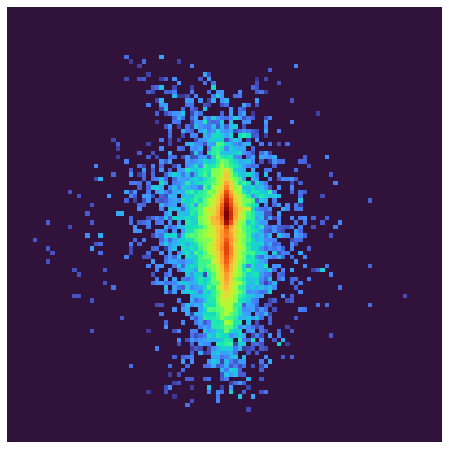

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(arr_bb, cmap= 'turbo', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

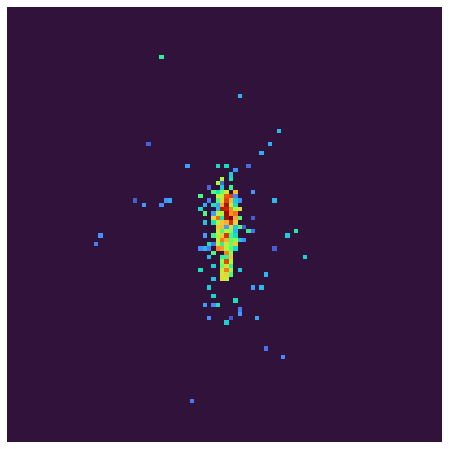

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(arr_bb10, cmap= 'turbo', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

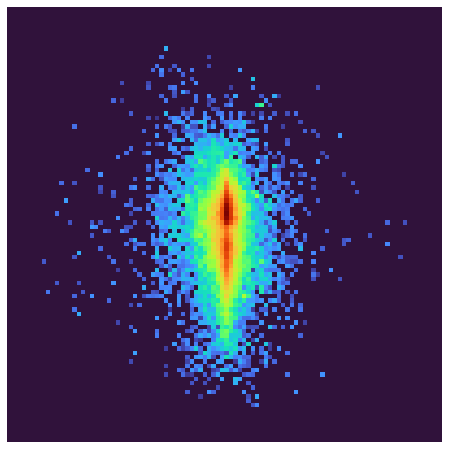

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(arr_cc, cmap= 'turbo', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

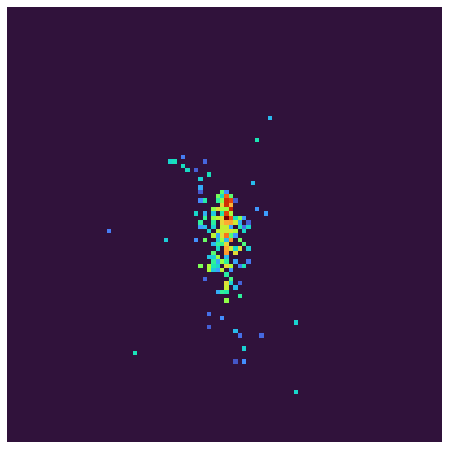

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(arr_cc10, cmap= 'turbo', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

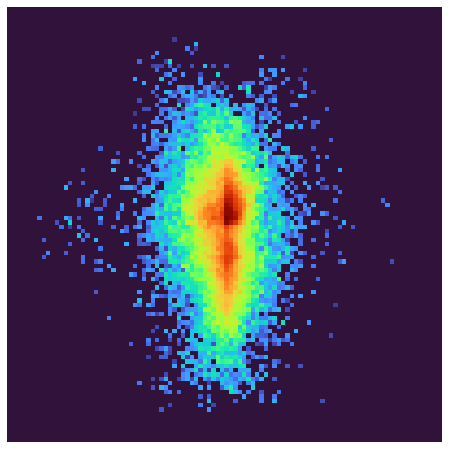

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(arr_ttbar, cmap= 'turbo', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

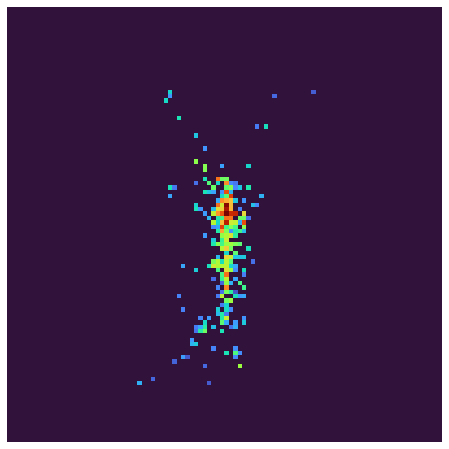

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(arr_ttbar10, cmap= 'turbo', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

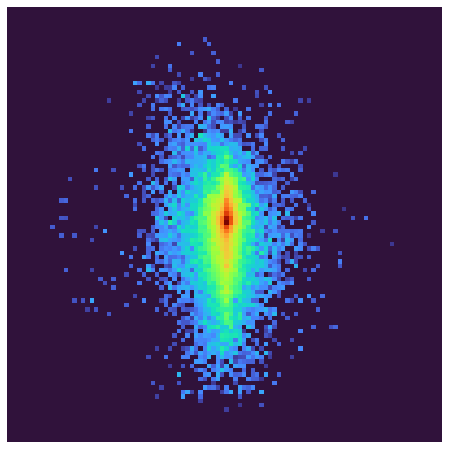

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(arr_qcd, cmap= 'turbo', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

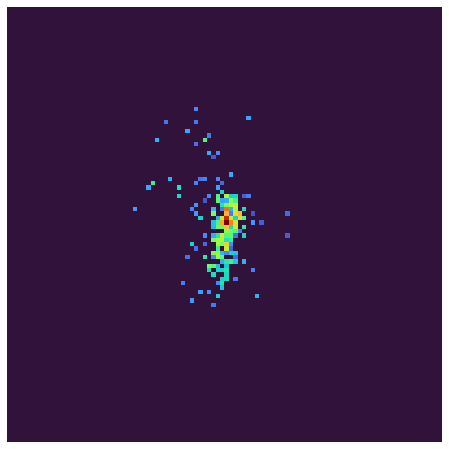

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(arr_qcd10, cmap= 'turbo', origin='lower')
plt.axis('off')